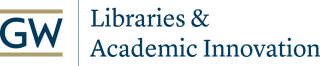

# Web Scraping: What You Need to Know

Web scraping is a technique for extracting data from web pages using code. While great tools exist in Python and other programming languages, scraping modern websites poses many challenges. This workshop will help you understand the structure of web pages and identify the features of a website that may make scraping easy, hard, or (in some cases) impossible. We'll walk through some examples together, using Python and the tools available in your web browser. Some prior familiarity with Python or another programming language is highly recommended.

**Instructors**: Matt Mihalik & Dolsy Smith

**Date & Time**: Tuesday, October 3, 10 am - 12 pm

**Location**: Gelman Library, Room 302 and [via Zoom](https://gwu-edu.zoom.us/my/laiworkshops)

## Outline

1. [A best-case scenario](#A-Best-Case-Scenario)
2. [Bot or Not](#Bot-or-Not) 
3. Anatomy of an HTTP request
4. How to act less like a bot
5. Other modes of bot detection
6. Hidden API's
7. Good citizen scraping

## A Best-Case Scenario 

At its simplest, a web page is a bunch of HTML tags enclosing some text (and maybe an image or two). Such **static** pages live on a web server (or else they are generated by the web server in response to an **HTTP request**). We call them _static_ because they don't change much. You might think of them like a Word document or PDF that someone sends you as an email attachment.

To scrape such pages, we need just a few tools.

But since nearly all web pages are written in HTML, as a minimum, it's helpful to have some sense of what **HTML** _is_.

### A very brief HTML primer

Take a look at this snippet of HTML. How would you describe the structure you see?

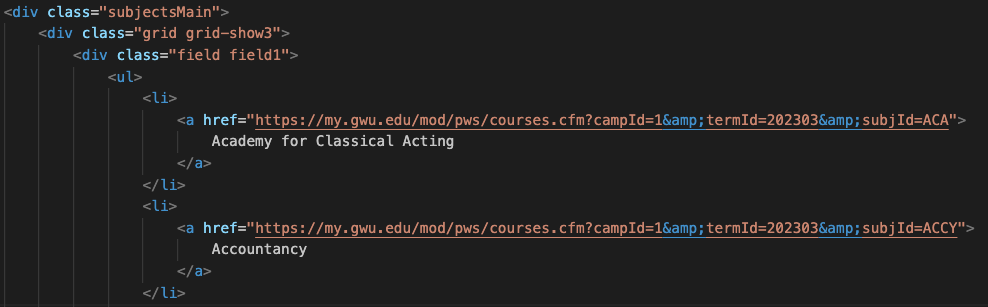

<details>
    <summary style="font-size:14pt">Click for a Hint</summary>
    <p></p>
    <p>Here are some things to keep in mind about HTML for the purposes of web scarping.</p>
    <ul>
        <li>HTML provides a set of <em>formatting</em> tags. The tags are, for the most part, not intended to describe document structure or content.</li>
        <li>HTML tags are <em>nested</em>. In the example, the <code>&lt;div&gt;</code> tags create three levels of container. The innermost container contains a <code>&lt;ul&gt;</code> tag, which creates an unordered (unnumbered) list.</li>
        <li>Within each <code>&lt;li&gt;</code> tag, which encloses a list element, the <code>&lt;a&gt;</code> tag creates a hyperlink.</li>
        <li>The URL to which the hyperlink leads is in the <code>href</code> <b>attribute</b> inside the <code>&lt;a&gt;</code> tag. An attribute allows additional data to be enclosed in an HTML tag. The data in attributes does not display, but it can be used by the browser to affect display of the page, or to provide other information (in this case, the URL for a link).</li>
        <li>The text that appears on the page -- in the labels on hyperlinks -- is enclosed within the <code>&lt;a&gt;</code> tags: <code>Academy for Classical Acting</code> and <code>Accountancy</code>.</li>
    </ul>
</details>

The snippet above is from the [GW Schedule of Classes](https://my.gwu.edu/mod/pws/subjects.cfm?campId=1&termId=202303). In what follows, we'll scrape this page to extract some course information. We'll use Python tools to do this.

There are two steps to scraping a web page (in the best-case scenario). 

### Step 1: Download the content

We'll use a Python library called `requests` to retrieve the HTML of this and other pages from the web. Many Python distributions come with requests pre-installed, but if you get a `ModuleNotFound` error running the following commands, run `!pip install requests` in a cell by itself, and then run the commands again.

In [ ]:
import requests

To scrape page, we start with a URL. In this case, the URL contains **parameters**, which tell the server to return specific kinds of information depending on the values of the parameters (campus and semester). 

Note that the presence of URL parameters doesn't mean that content is being **dynamically** loaded (i.e., in response to a user's actions in the browser). In this case, all the HTML on the page is being sent from the server at one time. That's part of what makes it a "best-case" scenario for scraping.

In [ ]:
depts_url = 'https://my.gwu.edu/mod/pws/subjects.cfm'
params = {'campus_id': '1', # Main Campus
            'term_id': '202303'}

With our URL and params in place, we can make our first request.

In [ ]:
depts_page = requests.get(depts_url, params=params)

Here `depts_page` is an HTTP response object. The value of `200` means that the request succeeded (returned the expected content). The content of the page -- the HTML -- is available under the `.text` property of the response object.

In [ ]:
depts_page

In [ ]:
depts_page.text

### Step 2. Parse the HTML

To scrape web pages written in HTML, we target the HTML tags using a tool called a **parser**. The parser recognizes valid HTML and allows us to extract the information enclosed in the tags: for instance, the labels and URL's in a list of departments. 

Before parsing this page with Python, we'll step away from the notebook for a moment to look at some browser tools that can help us identify which elements to target.

We'll use a library call [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to parse the HTML of this page. You may need to install it first, which you can do by running `!pip install beautifulsoup4` in a code cell below.

In [ ]:
from bs4 import BeautifulSoup


In [ ]:
soup = BeautifulSoup(depts_page.text, features="html.parser")

We can use the nested structure of HTML to target elements that are **children** (nested under) other elements. So if we want to retrieve all hyperlinks (`<a>` tags) inside the `<div>` with the `class` attribute value of `subjectsMain`, we can write the following:

In [ ]:
soup.find("div", class_="subjectsMain").find_all("a")

The `find_all` method returns a Python list of BeautifulSoup objects, one for each HTML element that matches our query. 

In web scraping, we usually don't care about the HTML elements themselves; we want the text or data inside them. In this case, let's extract all of the `href` values, since each `href` is a link to a page listing the courses in a given department.

In [ ]:
links = [l['href'] for l in soup.find("div", class_="subjectsMain").find_all("a")]

Note that `links` is a list of Python strings, each of which corresponds to a single URL. 

The URL's in `links` are not complete: note that they're missing the `gwu.edu` domain. But we can use them to reconstruct a complete URL to a course listings page by simply appending the string `'https://my.gwu.edu/mod/pws/'` to the beginning of each URL in `links`.

That way, we can automate scraping all the course schedule pages for the Fall 2023 semester, main campus. 

But before we proceed, it behooves us to look at the site's **robots.txt** file. Since the `mod/pws` directory is allowed, we can proceed to scrape knowing that we're not in violation of the website's policies.

#### Challenge

Can you write some Python code to retrieve all of the course-listing pages from the partial URL's in `links`? For now, just use the `requests` library to `get()` each page and store the page text in a list called `course_listings`. The following code stub will help you get started. 

In [ ]:
course_listings = []
for link in links:
    pass

<details>
    <summary style="font-size:14pt">Click for a Solution</summary>
<pre>
<code>
course_listings = []
for link in links:
    course_page = requests.get('https://my.gwu.edu/mod/pws/' + link)
    course_listings.append(course_page.text
</code>
</pre>
</details>

Now that we have downloaded the HTML for all the course listings, we could use BeautifulSoup to extract the course schedules from each HTML document. We won't step through that together in the interest of time, but see the [bonus material][#Bonus-Material] at the bottom of this notebook for a detailed example.

## Bot or Not

Each course entry on the course schedules pages includes a link to the course's page on eFollet.com, where you can see the assigned textbooks for that course. For instance, here's the eFollet page for [BISC 2450](https://www.bkstr.com/georgewashingtonstore/follett-discover-view/booklook?shopBy=discoverViewCourse&bookstoreId=122&termId=202303&divisionDisplayName=&departmentDisplayName=BISC&courseDisplayName=2450&sectionDisplayName=10).

So what happens if we try to request that page using the same methods as above?

In [ ]:
books = requests.get('https://www.bkstr.com/georgewashingtonstore/follett-discover-view/booklook?shopBy=discoverViewCourse&bookstoreId=122&termId=202303&divisionDisplayName=&departmentDisplayName=BISC&courseDisplayName=2450&sectionDisplayName=10')

In [ ]:
books

In [ ]:
books.text

Our request returns with a `403` status code, which is not a good sign. (Only something in the `200` range indicates a successful request.) And while the response does contain HTML, it's clearly not what we were expecting. So what went wrong?

We'll turn away from the notebook again to see how the browser tools can help us at this impasse. 